In [4]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, Future

from utils import *

mpl.rcParams.update(rcParams)
mpl.rcParams['figure.dpi'] = 100

In [5]:
%%bash
cd .. && make clean && make

rm: cannot remove 'data/*.out': No such file or directory
src/Ex3_2024.cpp:54:74: warning: unused parameter 't' [-Wunused-parameter]
        valarray<long double> get_f(const valarray<long double>& x, long double t) {
                                                                                ^
1 warning generated.


In [6]:
config_name = 'lagrange2Rprime'
conf = load_conf(config_name)

In [7]:
# Position Lagrange 2
G: float = 6.674e-11
d: float = 149.598023e9
ms: float = conf['m1']
mt: float = conf['m2']
xs = -mt * d / (mt + ms)
xt = ms * d / (mt + ms)
Omega = np.sqrt(G * ms / (d**2 * xt))
Omega2 = Omega**2
au = 1.495978707e11  # m / au

coefs = [
    Omega2,
    -2 * Omega2 * (xs+xt),
    Omega2 * ((xt + xs)**2 + 2 * xt * xs),
    -(G * (ms + mt) + 2 * Omega2 * xt * xs * (xt + xs)),
    2 * G * (ms * xt + mt * xs) + Omega2 * xt**2 * xs**2,
    -G * (ms * xt**2 + mt * xs**2)
]
roots = np.roots(coefs)
assert roots[2].imag == 0.0
L2x = roots[2].real
print(L2x)

151099098533.11984


In [ ]:
tFin = 2 * 365 * 24 * 60 * 60

all_params = (
    {
        'tol': 1e-3,
        'adapt': 'true',
        'tFin': tFin,
    },
)

count = 0
def done(fut: Future) -> None:
    global count
    count += 1
    print(f'\rRunning simulations... Done {count}/{len(all_params)}', end='')

# Run simulations *IN PARALLEL*
outputs = []
with ProcessPoolExecutor(max_workers=8) as p:
    for params in all_params:
        options = stringify_dict(params)
        output_file = f"{data_path}{config_name},{options}.out"
        outputs.append(output_file)
        future = p.submit(run, f'{config_path}{config_name}{config_ext}', output_file, params)
        future.add_done_callback(done)

# Load stuff in memory
all_data = []

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data.append((params, data))

Running simulations... Done 1/1

In [ ]:
def potential(x: float | np.ndarray, y: float | np.ndarray):
    # return x**2 + y**2
    return (
        -1.0 / 2.0 * Omega2 * (x**2 + y**2)
        # + Omega * (vy * x - vx * y)
        - G * ms / np.sqrt((x - xs)**2 + (y)**2)
        - G * mt / np.sqrt((x - xt)**2 + (y)**2)
    )

# Global

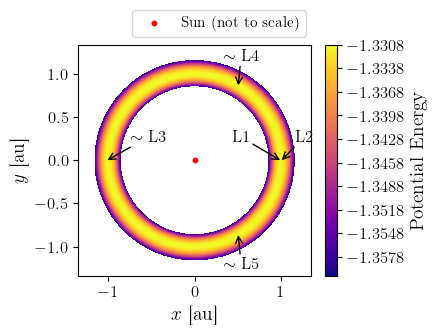

In [ ]:
%matplotlib inline
x0 = 0
y0 = 0
bounds = 2e11
x, y = np.meshgrid(
    np.linspace(x0-bounds, x0+bounds, 1000),
    np.linspace(y0-bounds, y0+bounds, 1000)
)
z = potential(x, y)
z = np.ma.masked_outside(z, -1.36e9, -1.1e9)

fig, ax = plt.subplots()
fig.set_size_inches(3.75, 3)
thing = ax.contourf(x/au, y/au, z/1e9, 100, cmap='plasma')

ax.scatter(xs/au, 0, s=10, marker='o', color='red', label='Sun (not to scale)')

ax.annotate('L1', ((xt - (L2x - xt))/au, 0), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.7, 0.6), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate('L2', (L2x/au, 0), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.97, 0.6), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate(r'$\sim$ L3', (-L2x/au, 0), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.3, 0.6), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate(r'$\sim$ L4', (L2x/au/2, xt/au * np.sqrt(3)/2), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.7, 0.95), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate(r'$\sim$ L5', (L2x/au/2, -xt/au * np.sqrt(3)/2), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.7, 0.05), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))

ax.set_xlabel(r'$x$ [au]')
ax.set_ylabel(r'$y$ [au]')
ax.axis('equal')

cbar = fig.colorbar(thing, ax=ax)
cbar.ax.set_ylabel(r"Potential Energy")
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.88))
plt.savefig(export_path + 'potential_global.png', dpi=300)
plt.show()

# Zoomed

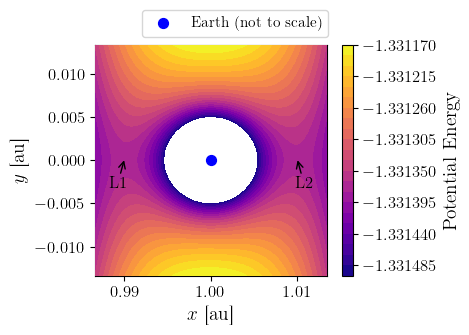

In [ ]:
%matplotlib inline
x0 = xt
y0 = 0
bounds = 2e9
x, y = np.meshgrid(
    np.linspace(x0-bounds, x0+bounds, 1000),
    np.linspace(y0-bounds, y0+bounds, 1000)
)
z = potential(x, y)
z = np.ma.masked_outside(z, -1.3315e9, -1.1e9)

fig, ax = plt.subplots()
fig.set_size_inches((3.75, 3))
thing = ax.contourf(x/au, y/au, z/1e9, 30, cmap='plasma', zorder=5)

ax.scatter(xt/au, 0, s=50, color='blue', marker='o', label='Earth (not to scale)')
ax.annotate('L1', ((xt - (L2x - xt))/au, 0), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.1, 0.4), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate('L2', (L2x/au, 0), zorder=10, ha='center', va='center', textcoords='axes fraction', xytext=(0.9, 0.4), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))

ax.set_xlabel(r'$x$ [au]')
ax.set_ylabel(r'$y$ [au]')
ax.axis('equal')

cbar = fig.colorbar(thing, ax=ax)
cbar.ax.set_ylabel(r"Potential Energy")
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.88))
plt.savefig(export_path + 'potential_L1_L2_zoom.png', dpi=300)
plt.show()

# Zoomed with trajectory

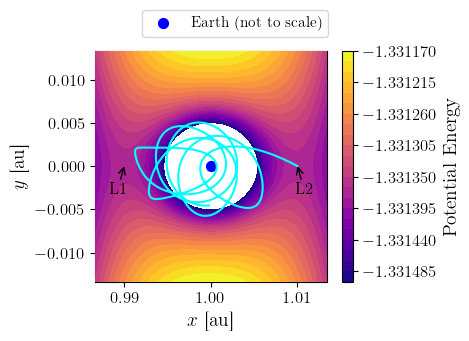

In [ ]:
%matplotlib inline
x0 = xt
y0 = 0
bounds = 2e9
x, y = np.meshgrid(
    np.linspace(x0-bounds, x0+bounds, 1000),
    np.linspace(y0-bounds, y0+bounds, 1000)
)
z = potential(x, y)
z = np.ma.masked_outside(z, -1.3315e9, -1.1e9)

fig, ax = plt.subplots()
fig.set_size_inches((3.75, 3))
thing = ax.contourf(x/au, y/au, z/1e9, 30, cmap='plasma', zorder=5)

data = all_data[0][1]
xp, yp = data[:,1], data[:,2]
ax.plot(xp/au, yp/au, color='aqua', zorder=5)

ax.scatter(xt/au, 0, s=50, color='blue', marker='o', label='Earth (not to scale)')
ax.annotate('L1', ((xt - (L2x - xt))/au, 0), zorder=10, color='black', ha='center', va='center', textcoords='axes fraction', xytext=(0.1, 0.4), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
ax.annotate('L2', (L2x/au, 0), zorder=10, color='black', ha='center', va='center', textcoords='axes fraction', xytext=(0.9, 0.4), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))

ax.set_xlabel(r'$x$ [au]')
ax.set_ylabel(r'$y$ [au]')
ax.axis('equal')

cbar = fig.colorbar(thing, ax=ax)
cbar.ax.set_ylabel(r"Potential Energy")
fig.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5, 0.9))
plt.savefig(export_path + 'potential_L1_L2_zoom_trajectory.png', dpi=300)
plt.show()

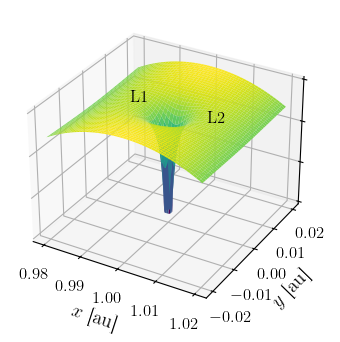

In [ ]:
%matplotlib inline
x0 = xt
y0 = 0
bounds = 3e9
x, y = np.meshgrid(
    np.linspace(x0-bounds, x0+bounds, 4000),
    np.linspace(y0-bounds, y0+bounds, 4000)
)
z = potential(x, y)
z = np.ma.masked_outside(z, -1.3338e9, -1.1e9)

plt.figure(figsize=(4, 4), )
ax = plt.subplot(projection='3d')
thing = ax.plot_surface(x/au, y/au, z/1e9, cmap='viridis', zorder=1)

ax.text((2*xt - L2x)/au, 0, potential(2*xt - L2x, 0)/1e9, 'L1', zorder=10)
ax.text(L2x/au, 0, potential(L2x, 0)/1e9, 'L2', zorder=10)

ax.set_xlabel(r'$x$ [au]')
ax.set_ylabel(r'$y$ [au]')
ax.set_zlabel(r'$z$ [$\sim J$]')
ax.set_zlim(-1.334, -1.331)
ax.set_zticklabels([])

plt.savefig(export_path + 'potential3D_L1_L2_zoom.png', dpi=300)
plt.show()

# Away it goes (modify C++)

In [ ]:
%%bash
cd .. && make clean && make

src/Ex3_2024.cpp:55:74: warning: unused parameter 't' [-Wunused-parameter]
   55 |         valarray<long double> get_f(const valarray<long double>& x, long double t) {
      |                                                                                 ^
1 warning generated.


Running simulations... Done 1/1


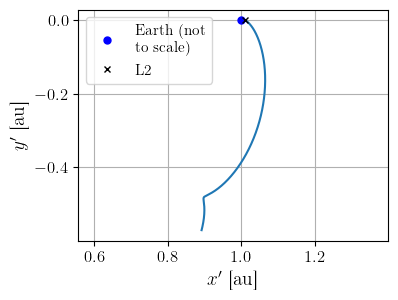

In [ ]:
params, data = run_with_params(
    config_name,
    [{
        'adapt': 'true',
        'tol': 1e-4,
        'tFin': tFin
    }]
)[0]

au = 1.495978707e11  # m / au

t, x, y, vx, vy, emec, nsteps = [data[:,i] for i in range(7)]

plt.plot(x/au, y/au)
plt.plot(xt/au, 0, 'o', color='blue', label='Earth (not\nto scale)', markersize=5, zorder=2)
plt.plot(L2x/au, 0, 'x', color='black', label='L2', markersize=5, zorder=2)

plt.xlabel(r"$x'$ [au]")
plt.ylabel(r"$y'$ [au]")
plt.axis('equal')
plt.legend()
plt.grid()
plt.savefig(export_path + 'lagrange_v0_up.pdf')